In [6]:
import time
import numpy as np
import pylab as pl

from IPython import display

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [8]:
compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])


In [9]:
train_data = datasets.MNIST(root="./mnist_data/", train=True, transform=compose, download=True)
test_data = datasets.MNIST(root="./mnist_data/", train=False, transform=compose, download=True)


In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mnist_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.5], std=[0.5])
                         )
    Target Transforms (if any): None

In [11]:
train_load = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_load = DataLoader(dataset=test_data, batch_size=128, shuffle=False)


In [12]:
train_load

Image shape: (28, 28)


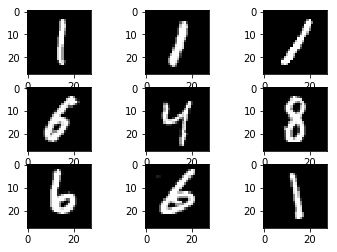

Predictions : [array(1), array(1), array(1), array(6), array(4), array(8), array(6), array(6), array(1)]


In [13]:
pred = []
for i, data in enumerate(train_load):
    pl.subplot(3, 3, i+1)
    img = data[0][i].data.numpy()
    img = np.squeeze(img)
    pl.imshow(img, cmap='gray')
    pred.append(data[1][i].data.numpy())
    if i+1 == 9:
        print("Image shape: " + str(img.shape))
        break
pl.show()
print("Predictions : " + str(pred))


In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784, 512),
                                    nn.LeakyReLU(0.2))
        
        self.layer2 = nn.Sequential(nn.Linear(512, 256),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3))
        
        self.layer3 = nn.Sequential(nn.Linear(256, 1),
                                    nn.Sigmoid())
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

In [17]:
Discriminator()


Discriminator(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3)
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(100, 256),
                                    nn.LeakyReLU(0.2))
        
        self.layer2 = nn.Sequential(nn.Linear(256, 512),
                                    nn.LeakyReLU(0.2))
        
        self.layer3 = nn.Sequential(nn.Linear(512, 784),
                                    nn.Tanh())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x


In [19]:
Generator()


Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [20]:
disc = Discriminator()
gen = Generator()

criterion = nn.BCELoss()
optimizer_gen = optim.Adam(gen.parameters(), lr = 0.0001)
optimizer_disc = optim.Adam(disc.parameters(), lr = 0.0001)

total_params = sum(p.numel() for p in disc.parameters() if p.requires_grad)
print("Discriminator parameters : {}".format(total_params))

total_params = sum(p.numel() for p in gen.parameters() if p.requires_grad)
print("Generator parameters : {}".format(total_params))


Discriminator parameters : 533505
Generator parameters : 559632


In [21]:
def train_disc(real_imgs, fake_imgs, real_labels, fake_labels):
    disc.train()
    optimizer_disc.zero_grad()
    
    real_outputs = disc(real_imgs)
    real_loss = criterion(real_outputs, real_labels)
    
    fake_outputs = disc(fake_imgs)
    fake_loss = criterion(fake_outputs, fake_labels)
    
    loss = real_loss + fake_loss
    
    loss.backward()
    optimizer_disc.step()
    
    return loss


In [22]:
def train_gen(fake_inputs, real_labels):
    gen.train()
    optimizer_gen.zero_grad()
    
    outputs = disc(fake_inputs)
    
    gen_loss = criterion(outputs, real_labels)
    
    gen_loss.backward()
    optimizer_gen.step()
    
    return gen_loss


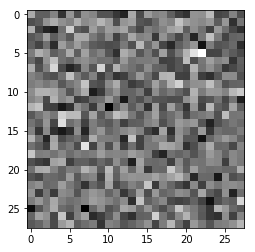

In [23]:
noise = Variable(torch.randn(100))
fake_imgs = gen(noise)
img = fake_imgs.view(1, 28, 28).data.numpy()
img = np.squeeze(img)
pl.imshow(img, cmap='gray')
pl.show()


Epoch : 9 Step : 468 Discriminator Loss : 0.2078033685684204 Generator Loss : 3.9224488735198975


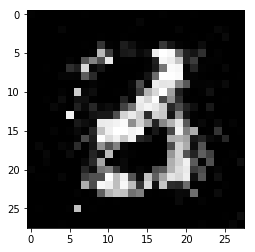

In [28]:
epochs = 10

for epoch in range(epochs):
    for i, data in enumerate(train_load):
        real_imgs, _ = data

        disc_noise = Variable(torch.randn(real_imgs.size(0), 100), requires_grad = False)

        fake_imgs = gen(disc_noise).detach()

        real_labels = Variable(torch.ones(real_imgs.size(0)), requires_grad = False)
        fake_labels = Variable(torch.zeros(real_imgs.size(0)), requires_grad = False)

        disc_loss = train_disc(Variable(real_imgs), fake_imgs, real_labels, fake_labels)

        gen_noise = Variable(torch.randn(real_imgs.size(0), 100), requires_grad = False)

        gen_img = gen(gen_noise)

        g_loss = train_gen(gen_img, real_labels)
    
        if i%100 == 0:
            img = gen_img[0].view(1, 28, 28).data.numpy()
            img = np.squeeze(img)
            pl.imshow(img, cmap='gray')
            display.clear_output(wait=True)
            display.display(pl.gcf())
            print("Epoch : {} Step : {} Discriminator Loss : {} Generator Loss : {}".format(epoch, i, disc_loss, g_loss))
            
    display.clear_output(wait=True)
    print("Epoch : {} Step : {} Discriminator Loss : {} Generator Loss : {}".format(epoch, i, disc_loss, g_loss))


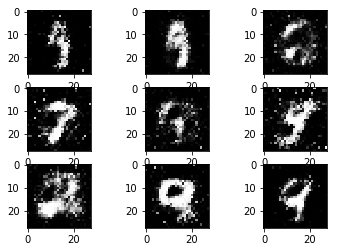

In [30]:
for k in range(9):
    pl.subplot(3, 3, k+1)
    disc_noise = Variable(torch.randn(100))
    fake_imgs = gen(disc_noise)
    img = fake_imgs.view(1, 28, 28).data.numpy()
    img = np.squeeze(img)
    pl.imshow(img, cmap='gray')  
pl.show()
